# *Cross validation* I: Treinamento, Validação e Teste

### Índice <a name="topo"></a>
- 1. [Introdução](#1)
- 2. [Carregando a base](#2)
- 3. [Base de Treinamento, Validação e Teste](#3)
- 4. [Cálculo dos CCP-alphas](#4)
- 5. [Obtendo a melhor árvore](#5)
- 6. [Avaliando a melhor árvore](#6)
- 7. [Gancho para a próxima aula](#7)


### 1. Introdução <a name="1"></a>
[Voltar para o índice](#topo)

O gancho da aula passada:

- Será que "demos sorte" de a base de testes ter esse desempenho?  
- Com outra base teriamos o mesmo desempenho?  
- Como podemos obter uma métrica mais "confiável" do desempenho desse algoritmo?

Na aula passada, como a base de testes foi utilizada para 'tunar' o modelo, é razoável imaginarmos que ao aplicar o modelo a uma base mais ampla, não vamos obter exatamente esta acurácia.

Vamos fazer uma primeira tentativa de resolver este problema separando uma base de testes *holdout*, que não será utilizada nem no desenvolvimento do modelo, nem na escolha dos hiperparâmetros, e no final, vamos avaliar a qualidade do modelo nesta base.

### 2. Carregando a base<a name="2"></a>
[Voltar para o índice](#topo)

Nesta aula vamos carregar a base já tratada na aula passada, com os valores faltantes da variável ```sex``` preenchidos.

In [57]:
import pandas            as pd 
import numpy             as np 
import seaborn           as sns
import matplotlib.pyplot as plt
from sklearn.tree            import DecisionTreeClassifier
from sklearn.metrics         import accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree

In [71]:
with open('features.txt', 'r') as f:
    features = pd.Series([line.strip() for line in f])

feature_names = features.str.extract(r'\d+\s+(.*)')[0].tolist()

with open('test/subject_test.txt', 'r') as f:
    subject_test = pd.Series([int(line.strip()) for line in f]) 

with open('test/y_test.txt', 'r') as f:
    y_test = pd.Series([int(line.strip()) for line in f]) 

with open('train/y_train.txt', 'r') as f:
    y_train = pd.Series([int(line.strip()) for line in f]) 

with open('train/subject_train.txt', 'r') as f:
    subject_train = pd.Series([int(line.strip()) for line in f]) 

selected_columns = ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']

X_train = pd.read_csv('train/X_train.txt', delim_whitespace=True, header=None)
X_train.columns = feature_names
X_train.insert(0, 'subject', subject_train)
X_train_selected = X_train[selected_columns]

X_test = pd.read_csv('test/X_test.txt', delim_whitespace=True, header=None)
X_test.columns = feature_names
X_test.insert(0,'subject', subject_test)
X_test_selected = X_test[selected_columns]

X_test_selected.index = pd.MultiIndex.from_arrays(
    [X_test.index, X_test['subject']],
    names=['order', 'subject']
)

X_train_selected.index = pd.MultiIndex.from_arrays(
    [X_train.index, X_train['subject']],
    names=['order', 'subject']
)

caminho = DecisionTreeClassifier(random_state=2360873,min_samples_leaf=20,max_depth=4).cost_complexity_pruning_path(X_train_selected, y_train)
ccp_alphas = caminho.ccp_alphas
ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])


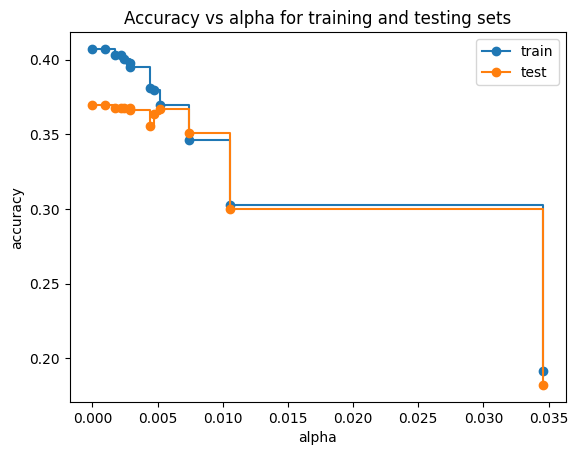

In [72]:
trees = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        random_state=2360873,
        min_samples_leaf=20,
        max_depth=4,
        ccp_alpha=alpha
    )
    clf.fit(X_train_selected, y_train)
    trees.append(clf)

train_scores = [clf.score(X_train_selected, y_train) for clf in trees]
test_scores = [clf.score(X_test_selected, y_test) for clf in trees]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from ipywidgets import interact, IntSlider
import numpy as np

def plot_pruning(max_depth=25, min_samples_leaf=200):
    clf_base = DecisionTreeClassifier(
        random_state=2360873,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf
    )
    
    path = clf_base.cost_complexity_pruning_path(X_train_selected, y_train)
    ccp_alphas = path.ccp_alphas

    trees = []
    for alpha in ccp_alphas:
        clf = DecisionTreeClassifier(
            random_state=2360873,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            ccp_alpha=alpha
        )
        clf.fit(X_train_selected, y_train)
        trees.append(clf)

    train_scores = [clf.score(X_train_selected, y_train) for clf in trees]
    test_scores = [clf.score(X_test_selected, y_test) for clf in trees]

    plt.figure(figsize=(10, 5))
    plt.plot(ccp_alphas, train_scores, marker='o', label='Train', drawstyle="steps-post")
    plt.plot(ccp_alphas, test_scores, marker='o', label='Test', drawstyle="steps-post")
    plt.xlabel("ccp_alpha")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy vs alpha | max_depth={max_depth}, min_samples_leaf={min_samples_leaf}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Activate interactivity
interact(
    plot_pruning,
    max_depth=IntSlider(value=25, min=1, max=50, step=1, description='Max Depth'),
    min_samples_leaf=IntSlider(value=200, min=1, max=1000, step=10, description='Min Leaf')
)

interactive(children=(IntSlider(value=25, description='Max Depth', max=50, min=1), IntSlider(value=200, descri…

<function __main__.plot_pruning(max_depth=25, min_samples_leaf=200)>

In [73]:
pd.DataFrame({'ccp_alpha':ccp_alphas, 'train_score':train_scores,'test_score':test_scores})

,ccp_alpha,train_score,test_score
0,0.000000,0.407100,0.369868
1,0.000993,0.407100,0.369868
2,0.001764,0.402748,0.367492
3,0.002188,0.402748,0.367492
4,0.002407,0.400435,0.367492
5,0.002876,0.397987,0.367492
6,0.002904,0.395267,0.366474
7,0.004400,0.380985,0.355277
8,0.004730,0.379761,0.363420
9,0.005218,0.369287,0.366814


In [74]:
clf_podada = DecisionTreeClassifier(random_state=2360873, ccp_alpha=0.000993)

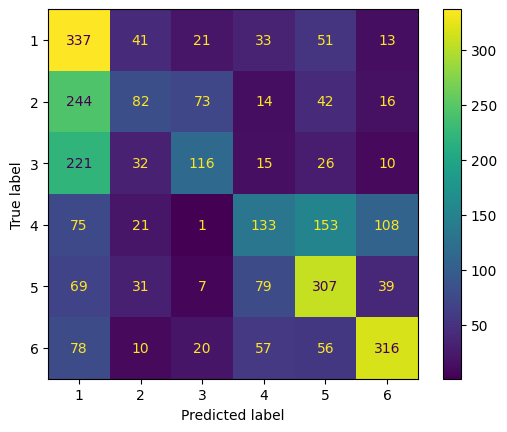

In [75]:
clf_podada.fit(X_train_selected, y_train)
predictions = clf_podada.predict(X_test_selected)
disp = ConfusionMatrixDisplay.from_estimator(clf_podada, X_test_selected, y_test)
accuracy = accuracy_score(y_test, predictions)

                  precision    recall  f1-score   support

    Not Upstairs       0.85      0.99      0.92      2476
WALKING_UPSTAIRS       0.64      0.09      0.16       471

        accuracy                           0.85      2947
       macro avg       0.74      0.54      0.54      2947
    weighted avg       0.82      0.85      0.79      2947



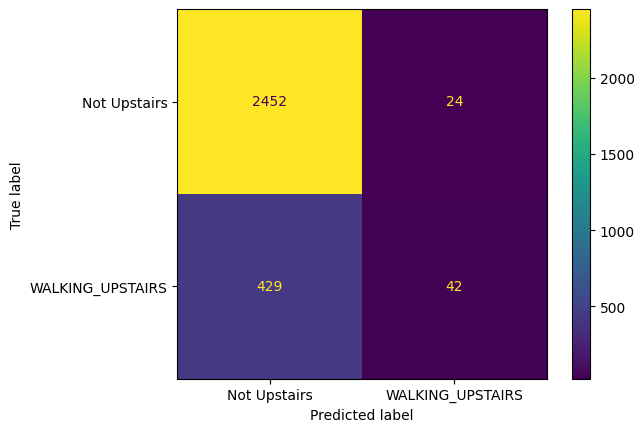

In [ ]:
y_train_bin = (y_train == 2).astype(int)
y_test_bin = (y_test == 2).astype(int)
from sklearn.tree import DecisionTreeClassifier

clf_bin = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,  # ajuste conforme necessário
    min_samples_leaf=10
)

clf_bin.fit(X_train_selected, y_train_bin)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred_bin = clf_bin.predict(X_test_selected)

print(classification_report(y_test_bin, y_pred_bin, target_names=["Not Upstairs", "WALKING_UPSTAIRS"]))

# Matriz de confusão
cm = confusion_matrix(y_test_bin, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Upstairs", "WALKING_UPSTAIRS"])
disp.plot(cmap='viridis')
plt.show()

In [77]:
import pandas as pd

feature_importance = pd.Series(clf_bin.feature_importances_, index=X_train_selected.columns)
print(feature_importance.sort_values(ascending=False).head(10))

tBodyAcc-mean()-X    0.434368
tBodyAcc-mean()-Y    0.430525
tBodyAcc-mean()-Z    0.135107
dtype: float64


In [66]:
pred = clf_podada.predict(X_test_selected)
accuracy_score(y_test, pred)

0.43807261621988464

In [78]:
classifier = DecisionTreeClassifier(random_state=2360873)
grid_params = {'ccp_alpha':ccp_alphas}
grid_params

{'ccp_alpha': array([0.        , 0.00099256, 0.00176395, 0.00218766, 0.00240709,
        0.00287647, 0.00290352, 0.00440039, 0.00473006, 0.0052179 ,
        0.00739929, 0.01053951, 0.03459538])}

In [79]:
grid = GridSearchCV(estimator=classifier, param_grid = grid_params, cv=15,verbose=0)
grid.fit(X_train_selected, y_train)

GridSearchCV(cv=15, estimator=DecisionTreeClassifier(random_state=2360873),
             param_grid={'ccp_alpha': array([0.        , 0.00099256, 0.00176395, 0.00218766, 0.00240709,
       0.00287647, 0.00290352, 0.00440039, 0.00473006, 0.0052179 ,
       0.00739929, 0.01053951, 0.03459538])})

In [80]:
grid

GridSearchCV(cv=15, estimator=DecisionTreeClassifier(random_state=2360873),
             param_grid={'ccp_alpha': array([0.        , 0.00099256, 0.00176395, 0.00218766, 0.00240709,
       0.00287647, 0.00290352, 0.00440039, 0.00473006, 0.0052179 ,
       0.00739929, 0.01053951, 0.03459538])})

In [81]:
resultados = pd.DataFrame(grid.cv_results_)

In [82]:
resultados.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.027925,0.001591,0.001263,0.000442,0.000000,{'ccp_alpha': 0.0},0.350305,0.311609,0.408163,0.369388,...,0.446939,0.424490,0.400000,0.442857,0.402041,0.381633,0.406122,0.389162,0.035621,7
1,0.033210,0.000899,0.001263,0.000440,0.000993,{'ccp_alpha': 0.0009925578776407706},0.448065,0.362525,0.479592,0.448980,...,0.479592,0.459184,0.385714,0.495918,0.506122,0.463265,0.491837,0.443971,0.043867,1
2,0.033480,0.000835,0.001123,0.000343,0.001764,{'ccp_alpha': 0.0017639483015495644},0.433809,0.356415,0.469388,0.408163,...,0.418367,0.424490,0.346939,0.457143,0.487755,0.444898,0.465306,0.421117,0.040007,2
3,0.033526,0.001137,0.001130,0.000338,0.002188,{'ccp_alpha': 0.00218765586899472},0.411405,0.348269,0.467347,0.406122,...,0.414286,0.436735,0.342857,0.455102,0.471429,0.436735,0.436735,0.414318,0.040290,3
4,0.033103,0.000632,0.001063,0.000250,0.002407,{'ccp_alpha': 0.0024070945610311922},0.401222,0.354379,0.467347,0.395918,...,0.414286,0.432653,0.342857,0.455102,0.467347,0.434694,0.432653,0.412414,0.039235,4
5,0.032960,0.000947,0.001130,0.000338,0.002876,{'ccp_alpha': 0.0028764717667856283},0.413442,0.386965,0.463265,0.387755,...,0.414286,0.416327,0.351020,0.438776,0.469388,0.430612,0.428571,0.412000,0.034310,6
6,0.032341,0.000424,0.001263,0.000442,0.002904,{'ccp_alpha': 0.0029035238969861467},0.413442,0.393075,0.463265,0.387755,...,0.414286,0.416327,0.344898,0.438776,0.469388,0.430612,0.428571,0.412407,0.035058,5
7,0.033134,0.000970,0.001263,0.000440,0.004400,{'ccp_alpha': 0.004400394494202681},0.415479,0.350305,0.406122,0.379592,...,0.383673,0.383673,0.330612,0.395918,0.442857,0.387755,0.389796,0.380848,0.034624,8
8,0.033803,0.000801,0.001063,0.000247,0.004730,{'ccp_alpha': 0.004730061257202697},0.409369,0.350305,0.406122,0.365306,...,0.393878,0.355102,0.314286,0.395918,0.434694,0.387755,0.397959,0.376631,0.035728,9
9,0.033474,0.000918,0.001262,0.000441,0.005218,{'ccp_alpha': 0.005217899399032111},0.407332,0.327902,0.400000,0.361224,...,0.379592,0.357143,0.314286,0.406122,0.416327,0.402041,0.385714,0.371873,0.035554,10


In [83]:
grid.best_index_

1

In [84]:
melhor_ccp = resultados.iloc[grid.best_index_,4]
clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=melhor_ccp).fit(X_train_selected, y_train)
clf.score(X_test_selected, y_test)

0.43807261621988464